<a href="https://colab.research.google.com/github/sarmi2325/Supervised_Learning/blob/main/churn_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Basic Cleanup
df = df.copy()
df = df.replace(" ", np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [ ]:
# Encode binary categorical features
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [ ]:
# Tenure group
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12','13-24','25-48','49-72'])

# Charges ratio
df['charges_ratio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)


# Long contract indicator
df['is_long_contract'] = df['Contract'].apply(lambda x: 1 if 'Two year' in x else 0)

# Support services available
df['has_support_services'] = ((df['OnlineSecurity'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)

# Multiple services
df['is_multiple_services'] = ((df['InternetService'] != 'No') & (df['PhoneService'] == 1)).astype(int)

# Encode categorical columns (label or one-hot as preferred)
df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod', 'InternetService', 'tenure_group'], drop_first=True)

df['total_services'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(lambda row: sum(row == 'Yes'), axis=1)

df['charge_per_months'] = df['TotalCharges'] / (df['tenure'] + 1)

df['is_streaming_heavy'] = ((df['StreamingTV'] == 'Yes') & (df['StreamingMovies'] == 'Yes')).astype(int)




In [ ]:
X = df.drop(['Churn', 'customerID'], axis=1)
X = pd.get_dummies(X, drop_first=True)

y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)


In [138]:
# Final SHAP-selected features (based on your plot)
selected_features = [
    'InternetService_Fiber optic',
    'tenure',
    'is_multiple_services',
    'total_services',
    'charges_ratio',
    'TechSupport_No internet service',
    'MultipleLines_Yes',
    'StreamingTV_Yes',
    'StreamingMovies_Yes',
    'tenure_group_49-72'
]

# Reduce dataset to only important features
X_train_v3 = X_train_sm[selected_features]
X_test_v3 = X_test[selected_features]


In [141]:
from xgboost import XGBClassifier
xgb_v3 = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_v3.fit(X_train_v3, y_train_sm)

# Wrap the trained model
calibrated_model = CalibratedClassifierCV(estimator=xgb_v3, method='isotonic', cv=5)
calibrated_model.fit(X_train_v3, y_train_sm)

# Predict
y_pred = calibrated_model.predict(X_test_v3)
y_proba = calibrated_model.predict_proba(X_test_v3)[:, 1]

# Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1549
           1       0.52      0.65      0.58       561

    accuracy                           0.75      2110
   macro avg       0.69      0.72      0.70      2110
weighted avg       0.77      0.75      0.76      2110

AUC Score: 0.8036747300598742


 96%|=================== | 2021/2110 [00:15<00:00]       

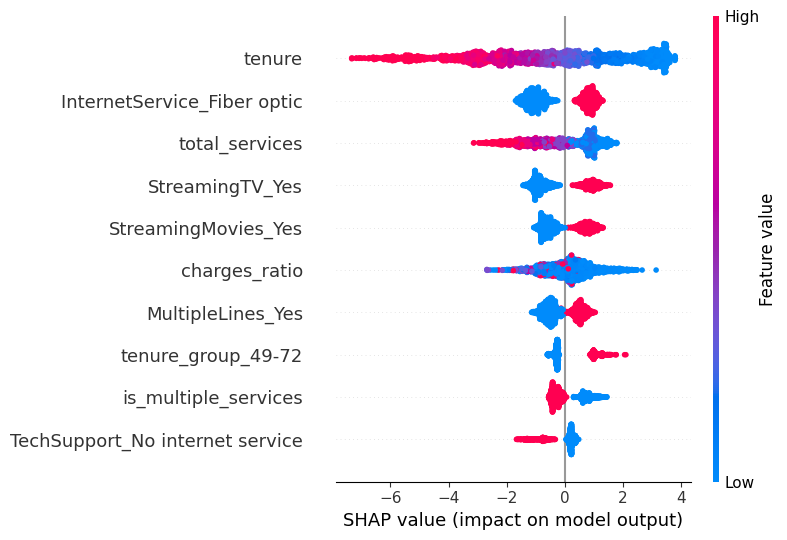

In [142]:
import shap
explainer = shap.Explainer(xgb_v3, X_train_v3)
shap_values = explainer(X_test_v3)
shap.summary_plot(shap_values, X_test_v3)
